This architecture consist of several inception blocks:
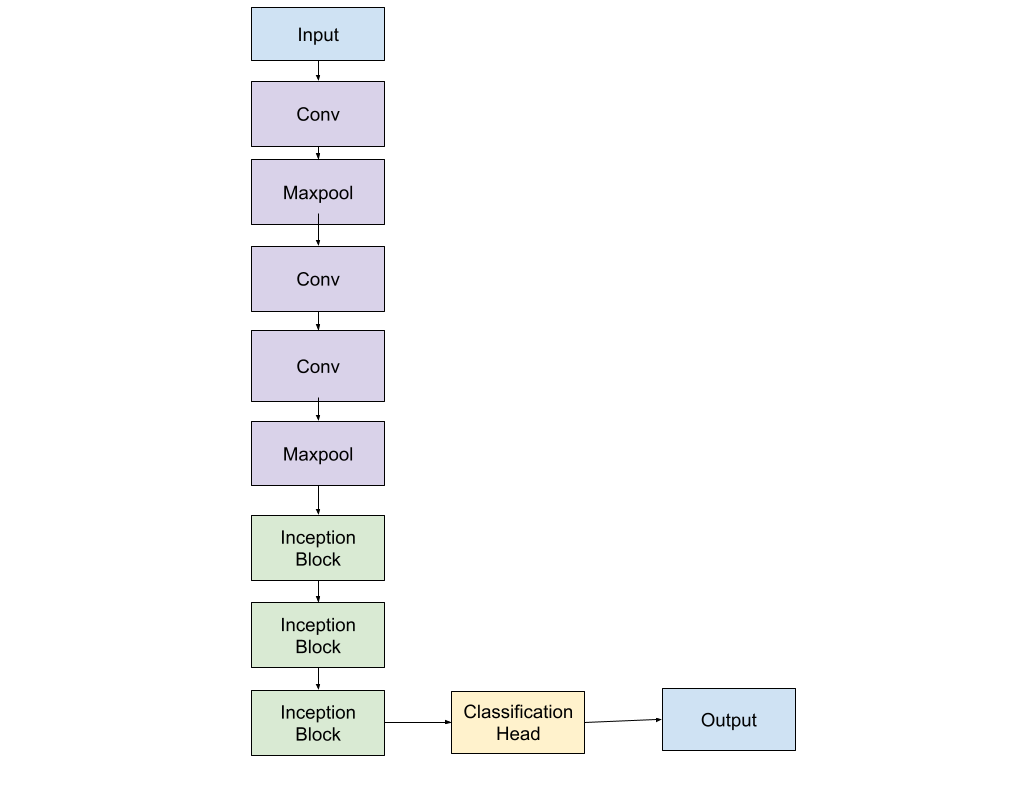

Each Inception Block has the following structure:
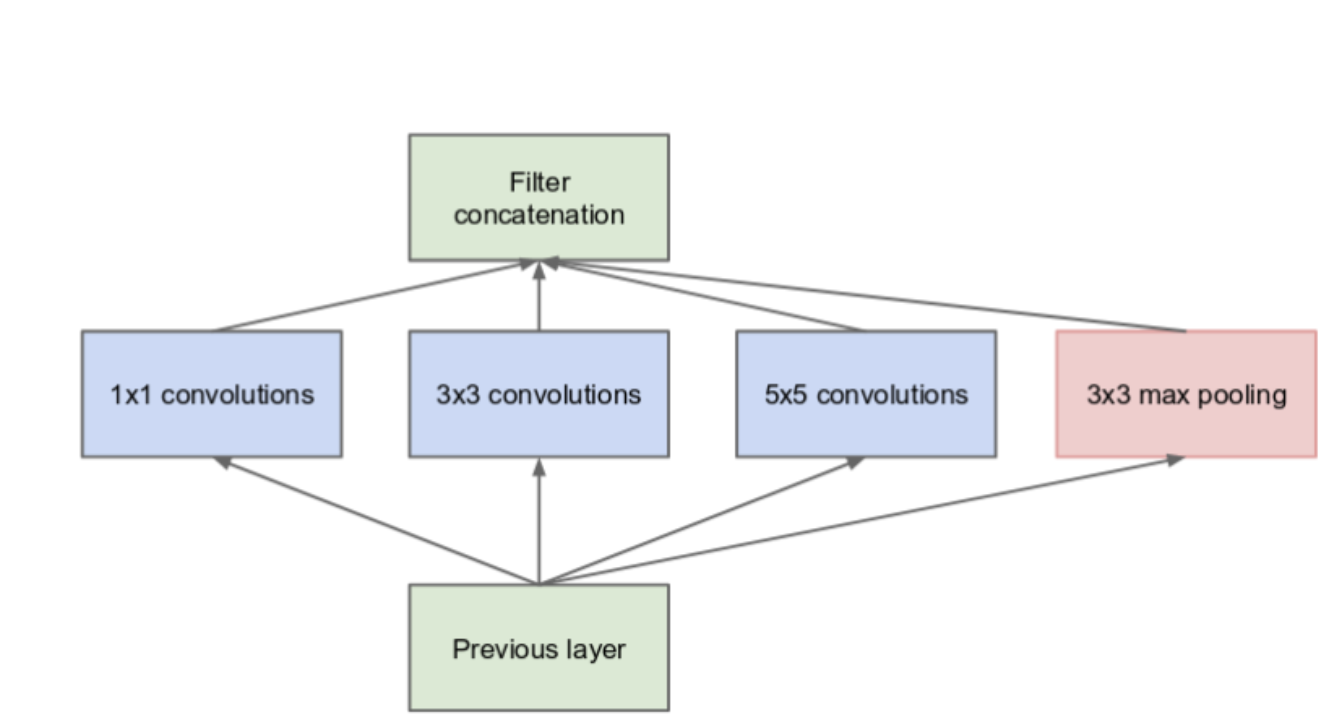

In [2]:
import tensorflow as tf

First of all we will implement the Inception block by subclassing the Keras Layers

In [8]:
class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, filters_c1, filters_c3, filters_c5, filters_pool, **kwargs):
        """
        filters_c1: number of filters of 1x1 conv layer
        filters_c3: number of filters of 3x3 conv layer
        filters_c5: number of filters of 5x5 conv layer
        filters_pool: number of filters for 1x1 conv after maxpool
        """
        super(InceptionBlock, self).__init__(**kwargs)

        # 1x1 conv
        self.conv1 = tf.keras.layers.Conv2D(filters_c1, (1,1), padding='same', activation='relu')

        # 3x3 conv
        self.conv3 = tf.keras.layers.Conv2D(filters_c3, (3,3), padding='same', activation='relu')

        # 5x5 conv
        self.conv5 = tf.keras.layers.Conv2D(filters_c5, (5,5), padding='same', activation='relu')

        # maxpool branch + 1x1 conv projection
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=1, padding='same')
        self.pool_proj = tf.keras.layers.Conv2D(filters_pool, (1,1), padding='same', activation='relu')

        # concatenation
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        branch1 = self.conv1(inputs)
        branch3 = self.conv3(inputs)
        branch5 = self.conv5(inputs)
        branch_pool = self.pool_proj(self.maxpool(inputs))

        out = self.concat([branch1, branch3, branch5, branch_pool])
        return out



Now write the whole model by subclassing the Keras Model class.

In [11]:
class MiniInception(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(MiniInception, self).__init__(**kwargs)
        # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
        self.conv_1 = tf.keras.layers.Conv2D(64 , (7,7) , strides=2,activation='relu',padding='same')

        # max-pooling layer: pool_size = (3,3), strides = 2
        self.maxpool_1 = tf.keras.layers.MaxPool2D((3,3) , strides=2 ,padding='same')

        # convolutional layer: filters = 64, strides = 1
        self.conv_2 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')

        # convolutional layer: filters = 192, kernel_size = (3,3)
        self.conv_3 = tf.keras.layers.Conv2D(192,(3,3),activation='relu',padding='same')

        # max-pooling layer: pool_size = (3,3), strides = 2
        self.maxpool_2 = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')
        # 1st Inception block
        self.block_1 = InceptionBlock(16,16,16,16)

        # 2nd Inception block
        self.block_2 = InceptionBlock(32,32,32,32)


        # max-pooling layer: pool_size = (3,3), strides = 2
        self.maxpool_3 = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')
        # 3rd Inception block
        self.block_3 = InceptionBlock(64,64,64,64)

        # Global Average pooling layer
        self.average_pool = tf.keras.layers.GlobalAveragePooling2D()

        # Dropoutlayer
        self.drop_out = tf.keras.layers.Dropout(0.2)

        # output layer
        self.dense = tf.keras.layers.Dense(num_classes,activation='softmax')


    def call(self, inputs):
        x=self.conv_1(inputs)
        x=self.maxpool_1(x)
        x=self.conv_2(x)
        x=self.conv_3(x)
        x=self.maxpool_2(x)
        x=self.block_1(x)
        x=self.block_2(x)
        x=self.maxpool_3(x)
        x=self.block_3(x)
        x=self.average_pool(x)
        x=self.drop_out(x)
        output=self.dense(x)
        return output


## Model Training

In [5]:
import tensorflow_datasets as tfds
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']
# load and preprocess the dataset
dataset = tfds.load('cifar10', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

In [6]:
dataset.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
inception = MiniInception(10)
inception.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception.fit(dataset, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.3138 - loss: 1.8258
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5508 - loss: 1.2500
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6247 - loss: 1.0641
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6682 - loss: 0.9434
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7040 - loss: 0.8439
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7287 - loss: 0.7713
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7513 - loss: 0.7042
Epoch 8/10
  70/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7506 - loss: 0.6942